In [1]:
!pip install geopandas
!pip install -U matplotlib


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

import scipy.sparse as sp, warnings
from sklearn.model_selection import ( 
    train_test_split, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, average_precision_score, classification_report, confusion_matrix
)

In [3]:
df = pd.read_csv("Crime.csv")
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,NaN,NaN,NaN,6000 COMEY AV,NaN,34.0339,-118.3747
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,4700 LA VILLA MARINA,NaN,33.9813,-118.4350


In [4]:
df.columns = [c.strip() for c in df.columns]

rename_map = {
    "Date Rptd": "Date_Reported",
    "DATE OCC": "Date_Occurred",
    "TIME OCC": "Time_Occurred",
    "AREA NAME": "Area_Name",
    "Rpt Dist No": "Reported_District_Num",
    "Part 1-2": "Part_1_2",
    "Crm Cd": "Crime_Code",
    "Crm Cd Desc": "Crime_Code_Desc",
    "Mocodes": "Mocodes",
    "Premis Desc": "Premis_Desc",
    "Weapon Desc": "Weapon_Desc",
    "Status Desc": "Status_Desc",
    "Vict Age": "Victim_Age",
    "Vict Sex": "Victim_Sex",
    "Vict Descent": "Victim_Descent",
    "LOCATION": "Location",
    "Cross Street": "Cross_Street",
    "LAT": "Latitude",
    "LON": "Longitude",
    "Crm Cd 1": "Crime_Cd_1",
    "Crm Cd 2": "Crime_Cd_2",
    "Crm Cd 3": "Crime_Cd_3",
    "Crm Cd 4": "Crim_Cd_4",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})


In [5]:
if "Date_Occurred" not in df.columns:
    raise KeyError("Expected 'Date_Occurred' column is missing after rename step.")

DATE_FMT = "%m/%d/%Y %I:%M:%S %p"

df["Date_Occurred_str"] = df["Date_Occurred"].astype("string").str.strip()

dt1 = pd.to_datetime(df["Date_Occurred_str"], format=DATE_FMT, errors="coerce")

mask_no_ampm = dt1.isna() & df["Date_Occurred_str"].str.match(
    r"^\d{1,2}/\d{1,2}/\d{2,4}\s+\d{1,2}:\d{2}:\d{2}$", na=False
)
if mask_no_ampm.any():
    dt2 = pd.to_datetime(df.loc[mask_no_ampm, "Date_Occurred_str"] + " AM",
                         format=DATE_FMT, errors="coerce")
    dt1 = dt1.combine_first(dt2)

df["Date_Occurred_dt"] = dt1

df["Occurred_Year"]  = df["Date_Occurred_dt"].dt.year
df["Occurred_Month"] = df["Date_Occurred_dt"].dt.month
df["Occurred_Day"]   = df["Date_Occurred_dt"].dt.day

In [6]:
def split_time_hhmm(series: pd.Series):
    s = series.astype("string").str.strip().str.replace(r"[^0-9]", "", regex=True)
    s = s.replace("", np.nan).str.zfill(4)
    hour = pd.to_numeric(s.str.slice(0, 2), errors="coerce")
    minute = pd.to_numeric(s.str.slice(2, 4), errors="coerce")
    hour = hour.mask((hour < 0) | (hour > 23))
    minute = minute.mask((minute < 0) | (minute > 59))
    return hour, minute

df["Hour"], df["Minute"] = split_time_hhmm(df["Time_Occurred"])


In [7]:
peek_cols = [
    "Date_Occurred", "Date_Occurred_dt", "Occurred_Year", "Occurred_Month", "Occurred_Day",
    "Time_Occurred", "Hour", "Minute",
]
print(df[ [c for c in peek_cols if c in df.columns] ].head(10))

            Date_Occurred Date_Occurred_dt  Occurred_Year  Occurred_Month  \
0  11/07/2020 12:00:00 AM       2020-11-07           2020              11   
1  10/18/2020 12:00:00 AM       2020-10-18           2020              10   
2  10/30/2020 12:00:00 AM       2020-10-30           2020              10   
3  12/24/2020 12:00:00 AM       2020-12-24           2020              12   
4  09/29/2020 12:00:00 AM       2020-09-29           2020               9   
5  11/11/2020 12:00:00 AM       2020-11-11           2020              11   
6  04/16/2020 12:00:00 AM       2020-04-16           2020               4   
7  07/07/2020 12:00:00 AM       2020-07-07           2020               7   
8  03/02/2020 12:00:00 AM       2020-03-02           2020               3   
9  09/01/2020 12:00:00 AM       2020-09-01           2020               9   

   Occurred_Day  Time_Occurred  Hour  Minute  
0             7            845     8      45  
1            18           1845    18      45  
2          

In [8]:
df["DayOfWeek"] = df["Date_Occurred_dt"].dt.day_name()

order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [9]:
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

df["Month_Name"] = df["Occurred_Month"].apply(
    lambda x: month_names[int(x)-1] if pd.notnull(x) and 1 <= int(x) <= 12 else None
)

In [10]:
   base = (
    df.dropna(subset=["Occurred_Year", "Hour"])
      .loc[lambda x: x["Hour"].between(0, 23)]
)

counts_h0 = (
    base.loc[base["Hour"] == 0]
        .groupby("Occurred_Year")
        .size()
        .rename("HOUR_0")
)

counts_h12_raw = (
    base.loc[base["Hour"] == 12]
        .groupby("Occurred_Year")
        .size()
        .rename("HOUR_12_raw")
)

if "Time_Occurred" in df.columns:
    mask_not_1200 = df["Time_Occurred"].astype("string").str.zfill(4) != "1200"
    counts_h12_no1200 = (
        base.loc[(base["Hour"] == 12) & mask_not_1200]
            .groupby("Occurred_Year")
            .size()
            .rename("HOUR_12_no1200")
    )
else:
    counts_h12_no1200 = pd.Series(dtype="int64", name="HOUR_12_no1200")

year_totals = (
    base.groupby("Occurred_Year")
        .size()
        .rename("TOTAL_YEAR")
)

summary = (
    pd.concat([year_totals, counts_h0, counts_h12_raw, counts_h12_no1200], axis=1)
      .fillna(0).astype(int)
      .reset_index()
      .sort_values("Occurred_Year")
)

print("Per-year counts (midnight vs noon):")
print(summary.to_string(index=False))


Per-year counts (midnight vs noon):
 Occurred_Year  TOTAL_YEAR  HOUR_0  HOUR_12_raw  HOUR_12_no1200
          2020      199847    8111        13753            5673
          2021      209876    8248        14278            6558
          2022      235259   10752        17153            8679
          2023      232345    9169        14798            7414
          2024      127567    4187         7824            4284
          2025          97       1            7               5


In [11]:
df["Time_Occurred_str"] = df["Time_Occurred"].astype(str).str.zfill(4)


zero_hour_entries = df[df["Hour"] == 0][["Time_Occurred", "Hour", "Minute"]]

print("Entries where Hour = 0:")
print(zero_hour_entries.head(25).to_string(index=False)) 
print(f"\nTotal entries with HOUR == 0: {len(zero_hour_entries):,}\n")

twelve_hour_entries = df[df["Hour"] == 12][["Time_Occurred", "Hour", "Minute"]]

print("Entries where Hour = 12:")
print(twelve_hour_entries.head(25).to_string(index=False))  # display first 25 neatly
print(f"\nTotal entries with HOUR == 12: {len(twelve_hour_entries):,}\n")

placeholder_mask = df["Time_Occurred_str"] == "1200"
placeholder_entries = df.loc[placeholder_mask, ["Time_Occurred", "Hour", "Minute"]]

print("Entries where Time_Occurred is placeholder (1200):")
print(placeholder_entries.head(25).to_string(index=False))
print(f"\nTotal placeholder entries (Time_Occurred == '1200'): {len(placeholder_entries):,}\n")

if "Occurred_Year" in df.columns:
    placeholder_by_year = (
        df.loc[placeholder_mask]
          .groupby("Occurred_Year")
          .size()
          .reset_index(name="Placeholder_Count")
    )

Entries where Hour = 0:
 Time_Occurred  Hour  Minute
             1     0       1
            30     0      30
             1     0       1
            30     0      30
            10     0      10
             1     0       1
             1     0       1
            40     0      40
            48     0      48
             5     0       5
             1     0       1
             1     0       1
             1     0       1
            45     0      45
             1     0       1
            45     0      45
             1     0       1
             1     0       1
             1     0       1
             1     0       1
             1     0       1
            44     0      44
            20     0      20
            20     0      20
            15     0      15

Total entries with HOUR == 0: 40,468

Entries where Hour = 12:
 Time_Occurred  Hour  Minute
          1240    12      40
          1210    12      10
          1200    12       0
          1200    12       0
          120

In [12]:
placeholder_mask = df["Time_Occurred"].astype(str).str.zfill(4) == "1200"
removed = placeholder_mask.sum()
df = df[~placeholder_mask].copy()

In [13]:
per_year_counts = (
    df.groupby(["Occurred_Year", "Hour"])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=range(24), fill_value=0)
           .sort_index()
)
pd.set_option("display.max_columns", None)  
print(per_year_counts)
pd.reset_option("display.max_columns")
print(per_year_counts.head(30))

Hour              0     1     2     3     4     5     6     7     8     9   \
Occurred_Year                                                                
2020            8111  5819  4968  4316  3607  3368  3969  4743  7093  7112   
2021            8248  6217  5415  4721  3941  3758  4347  5276  7666  7475   
2022           10752  7569  6130  5396  4637  4222  6096  6594  9113  8767   
2023            9169  6785  5837  5098  4316  3909  5585  6005  8611  8494   
2024            4187  3370  2864  2659  2255  2031  3187  3646  4760  4671   
2025               1     1     0     1     1     2     1     3     6     5   

Hour              10     11    12     13     14     15     16     17     18  \
Occurred_Year                                                                 
2020            8343   8400  5673   9062   9899  10772  10828  12114  12298   
2021            9165   9123  6558   9657  10148  10804  11091  12138  12418   
2022           10132  10490  8679  10334  11035  11919  116

In [14]:
def Is_Violent(desc: str) -> bool:
    """Classify a crime description as violent based on keywords."""
    if not isinstance(desc, str):
        return False
    d = desc.upper()
    patterns = [
        # Homicides
        "HOMICIDE", "CRIMINAL HOMICIDE", "MANSLAUGHTER", "MURDER", "LYNCHING",

        # Sex Crimes
        "RAPE", "SEXUAL ASSAULT", "SODOMY", "FORCIBLE RAPE", "ORAL COPULATION",
        "SEXUAL PENETRATION", "BATTERY WITH SEXUAL CONTACT", "LEWD", "INCEST",
        "HUMAN TRAFFICKING", "PANDERING", "PIMPING",

        # Robbery / Theft with Force
        "ROBBERY", "ATTEMPTED ROBBERY", "PURSE SNATCHING", "THEFT FROM PERSON", "BURGLARY",

        # Assault / Battery
        "ASSAULT", "BATTERY", "AGGRAVATED ASSAULT", "BRANDISH WEAPON", 
        "CHILD ABUSE", "INTIMATE PARTNER", "BATTERY POLICE", "BATTERY ON A FIREFIGHTER",

        # Kidnapping / False Imprisonment
        "KIDNAPPING", "FALSE IMPRISONMENT",

        # Weapons / Arson / Shooting
        "SHOOTING", "DISCHARGE FIREARM", "ARSON", "BOMB", "EXPLOSIVE",

        # Threats / Terror / Extortion
        "CRIMINAL THREATS", "EXTORTION", "TERRORIST", "THREATENING PHONE CALL",

        # Domestic Violence / Restraining Orders
        "VIOLATION OF RESTRAINING ORDER", "DOMESTIC VIOLENCE",

        # Other Violent / Dangerous
        "STALKING", "RIOT", "RESISTING ARREST", "BATTERY - SIMPLE ASSAULT"
    ]
    return any(p in d for p in patterns)

if "Crime_Code_Desc" in df.columns:
    df["Is_Violent"] = df["Crime_Code_Desc"].apply(Is_Violent)
else:
    df["Is_Violent"] = False

print(df[["Crime_Code_Desc", "Is_Violent"]].head(20))


                                      Crime_Code_Desc  Is_Violent
0                                   THEFT OF IDENTITY       False
1      ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT        True
2                                   THEFT OF IDENTITY       False
3   THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...       False
4     THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       False
5                                   THEFT OF IDENTITY       False
6                                   THEFT OF IDENTITY       False
7   CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...       False
9                                   THEFT OF IDENTITY       False
10  CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...       False
11                                  THEFT OF IDENTITY       False
12                                   VEHICLE - STOLEN       False
13                                           BURGLARY        True
14                              BURGLARY FROM VEHICLE        True
15        

In [15]:
if "Victim_Age" not in df.columns and "Vict Age" in df.columns:
    df = df.rename(columns={"Vict Age": "Victim_Age"})

df["Victim_Age"] = pd.to_numeric(df["Victim_Age"], errors="coerce")

n_non_numeric = df["Victim_Age"].isna().sum()
n_le_zero = (df["Victim_Age"] <= 0).sum(min_count=1)
print(f"Before fix — non-numeric/NaN: {n_non_numeric:,} | <= 0 ages: {int(n_le_zero):,}")

df.loc[df["Victim_Age"] <= 0, "Victim_Age"] = pd.NA

df["Victim_Age"] = df["Victim_Age"].astype("Int64")

n_le_zero_after = (df["Victim_Age"].fillna(pd.NA) <= 0).sum(min_count=1)
print(f"After fix — <= 0 ages: {int(n_le_zero_after or 0)}")

Before fix — non-numeric/NaN: 0 | <= 0 ages: 260,581
After fix — <= 0 ages: 0


In [16]:
df["Victim_Sex"].unique()

array(['M', 'F', nan, 'X', 'H', '-'], dtype=object)

In [17]:
if "Victim_Sex" not in df.columns and "Vict Sex" in df.columns:
    df = df.rename(columns={"Vict Sex": "Victim_Sex"})

df["Victim_Sex"] = df["Victim_Sex"].astype(str).str.strip().str.upper()

invalid_codes = [
    "", "-", "NAN", "NONE","H"
]
df["Victim_Sex"] = df["Victim_Sex"].replace(invalid_codes, "X")

sex_map = {
    "M": "Male",
    "F": "Female",
    "X": "Non-binary/Unknown"
}
df["Victim_Sex"] = df["Victim_Sex"].map(sex_map).fillna("Non-binary/Unknown")

print(df["Victim_Sex"].value_counts(dropna=False))

Victim_Sex
Male                  390610
Female                344650
Non-binary/Unknown    234531
Name: count, dtype: int64


In [18]:
df["Victim_Sex"].unique()

array(['Male', 'Female', 'Non-binary/Unknown'], dtype=object)

In [19]:
descent_map = {
    "A": "Other Asian", "B": "Black", "C": "Chinese", "D": "Cambodian",
    "F": "Filipino", "G": "Guamanian", "H": "Hispanic",
    "I": "American Indian/Alaskan Native", "J": "Japanese", "K": "Korean",
    "L": "Laotian", "O": "Other", "P": "Pacific Islander", "S": "Samoan",
    "U": "Hawaiian", "V": "Vietnamese", "W": "White", "X": "Unknown",
    "Z": "Asian Indian"
}
df["Victim_Descent"] = df["Victim_Descent"].str.upper().map(descent_map).fillna("Unknown")

# Logistic Regression

## Excluding Spatial and Temporal (has hours)

In [20]:
warnings.filterwarnings("ignore")

num_cols = ["Victim_Age", "Hour"]
cat_cols = ["Victim_Sex", "Victim_Descent", "DayOfWeek", "Occurred_Month", "AREA"]
target   = "Is_Violent"

work = df.dropna(subset=[target]).copy()
y = work[target].astype(int)
X = work[num_cols + cat_cols]

In [21]:
def make_ohe():
    try:
        # Newer sklearn: sparse_output
        return OneHotEncoder(drop=None, handle_unknown="ignore", sparse_output=True)
    except TypeError:
        # Older sklearn: sparse
        return OneHotEncoder(drop=None, handle_unknown="ignore", sparse=True)


In [22]:
numeric_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)) 
])
categorical_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0 
)

In [23]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_train_sp = pre.fit_transform(X_train_raw)
X_test_sp  = pre.transform(X_test_raw)

print("[LOG] Shapes (rows, cols): train", X_train_sp.shape, "| test", X_test_sp.shape)
if sp.issparse(X_train_sp):
    density = X_train_sp.nnz / (X_train_sp.shape[0] * X_train_sp.shape[1])
    print("[LOG] Sparse density (train):", round(density, 6))

[LOG] Shapes (rows, cols): train (678853, 64) | test (290938, 64)
[LOG] Sparse density (train): 0.108724


In [24]:
logit = LogisticRegression(
    solver="saga",
    penalty="l2",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    verbose=1
)
logit.fit(X_train_sp, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
Epoch 1, change: 1.00000000
Epoch 2, change: 0.15778632
Epoch 3, change: 0.07454061
Epoch 4, change: 0.05993311
Epoch 5, change: 0.02559612
Epoch 6, change: 0.01789291
Epoch 7, change: 0.01615629
Epoch 8, change: 0.01363212
Epoch 9, change: 0.01462394
Epoch 10, change: 0.01167256
Epoch 11, change: 0.00593668
Epoch 12, change: 0.00550760
Epoch 13, change: 0.00460219
Epoch 14, change: 0.00360197
Epoch 15, change: 0.00312267
Epoch 16, change: 0.00251250
Epoch 17, change: 0.00203704
Epoch 18, change: 0.00166758
Epoch 19, change: 0.00145014
Epoch 20, change: 0.00106225
Epoch 21, change: 0.00096122
Epoch 22, change: 0.00079463
Epoch 23, change: 0.00065561
Epoch 24, change: 0.00052250
Epoch 25, change: 0.00043522
Epoch 26, change: 0.00034731
Epoch 27, change: 0.00029607
Epoch 28, change: 0.00023525
Epoch 29, change: 0.00019703
Epoch 30, change: 0.00016919
Epoch 31, change: 0.00013559
Epoch 32, change: 0.00010427


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   solver='saga', verbose=1)

In [25]:
proba = logit.predict_proba(X_test_sp)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("LogisticRegression(SAGA) Results")
print(f"ROC AUC: {roc_auc_score(y_test, proba):.4f}")
print(f"PR  AUC: {average_precision_score(y_test, proba):.4f}")
print(classification_report(y_test, pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

LogisticRegression(SAGA) Results
ROC AUC: 0.7228
PR  AUC: 0.6291
              precision    recall  f1-score   support

           0      0.776     0.523     0.625    161181
           1      0.578     0.812     0.675    129757

    accuracy                          0.652    290938
   macro avg      0.677     0.668     0.650    290938
weighted avg      0.688     0.652     0.648    290938

Confusion matrix:
 [[ 84372  76809]
 [ 24413 105344]]


The logistic regression model was trained on roughly 776,000 records and tested on 194,000. It achieved a ROC AUC of 0.72 and a PR AUC of 0.63, showing moderate ability to distinguish violent from non-violent crimes. In this model, 1 represents violent crimes and 0 represents non-violent crimes. The model reached 65% accuracy, with recall of 0.81 for violent crimes and 0.52 for non-violent crimes, meaning it correctly identified most violent incidents but also produced some false positives. The confusion matrix shows 105,344 true positives and 76,809 false positives. These results serve as a baseline for comparison with more advanced models.

### Latex Table Transfer:

In [26]:
roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)
report_dict = classification_report(y_test, pred, output_dict=True)

metrics_df = pd.DataFrame({
    "Class": ["0 (Non-violent)", "1 (Violent)"],
    "Precision": [
        report_dict["0"]["precision"],
        report_dict["1"]["precision"]
    ],
    "Recall": [
        report_dict["0"]["recall"],
        report_dict["1"]["recall"]
    ],
    "F1-score": [
        report_dict["0"]["f1-score"],
        report_dict["1"]["f1-score"]
    ],
    "Support": [
        int(report_dict["0"]["support"]),
        int(report_dict["1"]["support"])
    ]
})

summary_df = pd.DataFrame({
    "Metric": ["ROC AUC", "PR AUC", "Accuracy"],
    "Value": [
        roc,
        pr,
        report_dict["accuracy"]
    ]
})

latex_summary = summary_df.to_latex(
    index=False,
    float_format=lambda x: f"{x:.4f}",
    caption="Overall performance metrics for logistic regression.",
    label="tab:logit_summary"
)

latex_metrics = metrics_df.to_latex(
    index=False,
    float_format=lambda x: f"{x:.3f}",
    caption="Classification report for logistic regression model.",
    label="tab:logit_class_report"
)

print(latex_summary)
print()
print(latex_metrics)


\begin{table}
\caption{Overall performance metrics for logistic regression.}
\label{tab:logit_summary}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
ROC AUC & 0.7228 \\
PR AUC & 0.6291 \\
Accuracy & 0.6521 \\
\bottomrule
\end{tabular}
\end{table}


\begin{table}
\caption{Classification report for logistic regression model.}
\label{tab:logit_class_report}
\begin{tabular}{lrrrr}
\toprule
Class & Precision & Recall & F1-score & Support \\
\midrule
0 (Non-violent) & 0.776 & 0.523 & 0.625 & 161181 \\
1 (Violent) & 0.578 & 0.812 & 0.675 & 129757 \\
\bottomrule
\end{tabular}
\end{table}



In [27]:
cm = confusion_matrix(y_test, pred)

cm_df = pd.DataFrame(
    cm,
    index=["Actual 0 (Non-violent)", "Actual 1 (Violent)"],
    columns=["Predicted 0", "Predicted 1"]
)

latex_cm = cm_df.to_latex(
    caption="Confusion matrix for logistic regression (threshold = 0.5).",
    label="tab:logit_confusion"
)

print(latex_cm)


\begin{table}
\caption{Confusion matrix for logistic regression (threshold = 0.5).}
\label{tab:logit_confusion}
\begin{tabular}{lrr}
\toprule
 & Predicted 0 & Predicted 1 \\
\midrule
Actual 0 (Non-violent) & 84372 & 76809 \\
Actual 1 (Violent) & 24413 & 105344 \\
\bottomrule
\end{tabular}
\end{table}



<hr>

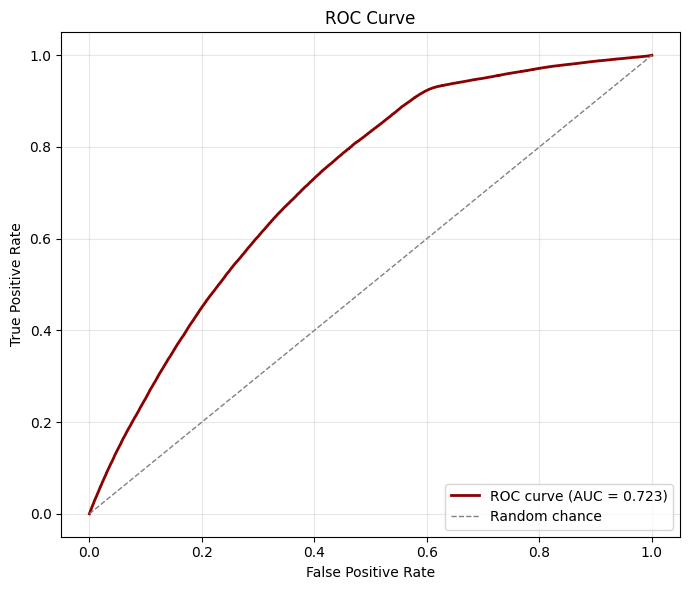

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(fpr, tpr, color="darkred", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--", label="Random chance")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
try:
    cat_names = ohe.get_feature_names_out(cat_cols)
except:
    # very old sklearn fallback
    cat_names = ohe.get_feature_names(cat_cols)

feature_names = np.array(num_cols + list(cat_names))
coefs = logit.coef_.ravel()
top_idx = np.argsort(np.abs(coefs))[-20:][::-1]

top_tbl = pd.DataFrame({
    "feature": feature_names[top_idx],
    "beta": coefs[top_idx],
    "odds_ratio": np.exp(coefs[top_idx])
})
print("\nTop 20 |beta| features:")
print(top_tbl.to_string(index=False))


Top 20 |beta| features:
                                      feature      beta  odds_ratio
                Victim_Sex_Non-binary/Unknown -1.450316    0.234496
                      Victim_Descent_Hispanic  0.980413    2.665558
                         Victim_Descent_Black  0.957082    2.604087
                   Victim_Descent_Other Asian  0.742855    2.101928
                      Victim_Descent_Japanese -0.703395    0.494902
                       Victim_Descent_Chinese -0.699109    0.497028
                       Victim_Descent_Laotian -0.686673    0.503247
                    Victim_Descent_Vietnamese -0.638970    0.527836
                         Victim_Descent_Other  0.545278    1.725088
                     Victim_Descent_Guamanian  0.467300    1.595680
                         Victim_Descent_White  0.464087    1.590562
                     Victim_Descent_Cambodian -0.451876    0.636433
                  Victim_Descent_Asian Indian -0.450594    0.637249
                      V

The logistic regression model identifies several demographic and area-related factors that influence the likelihood of a crime being classified as violent (1) versus non-violent (0). Positive coefficients (β > 0, odds ratio > 1) indicate a higher likelihood of violence, while negative coefficients (β < 0, odds ratio < 1) indicate a lower likelihood.

Victim descent had the strongest effects. Crimes involving Hispanic/Latin/Mexican or Black victims were over twice as likely to be violent compared to the baseline. In contrast, crimes involving Asian victims (such as Japanese, Chinese, Laotian, or Vietnamese) were less likely to be violent. The Non-binary/Unknown victim sex category had the lowest odds (odds ratio = 0.23), showing these cases were far less likely to be violent. Certain areas like AREA_15 and AREA_14 also had odds ratios below 1, meaning they tend to have fewer violent incidents compared to other divisions.

Overall, the results suggest that victim demographics and police division location are important predictors in whether a crime is classified as violent.

## Including Spatial and Temporal 

In [30]:
num_cols_st = ["Victim_Age", "Hour", "Latitude", "Longitude"]
cat_cols_st = [
    "Victim_Sex", 
    "Victim_Descent",
    "DayOfWeek",
    "Occurred_Year",
    "Occurred_Month",
    "Occurred_Day",
    "AREA"
]

target = "Is_Violent"

work_st = df.dropna(subset=[target]).copy()
y_st = work_st[target].astype(int)
X_st = work_st[num_cols_st + cat_cols_st]

In [31]:
numeric_pipe_st = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_pipe_st = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])

pre_st = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_st, num_cols_st),
        ("cat", categorical_pipe_st, cat_cols_st)
    ],
    remainder="drop",
    sparse_threshold=1.0
)

In [32]:
X_train_raw_st, X_test_raw_st, y_train_st, y_test_st = train_test_split(
    X_st, y_st, test_size=0.3, stratify=y_st, random_state=42
)

X_train_sp_st = pre_st.fit_transform(X_train_raw_st)
X_test_sp_st  = pre_st.transform(X_test_raw_st)

print("Spatial+Temporal Model Shapes:", X_train_sp_st.shape, X_test_sp_st.shape)

if sp.issparse(X_train_sp_st):
    print("Sparse density:", X_train_sp_st.nnz / (X_train_sp_st.shape[0] * X_train_sp_st.shape[1]))

Spatial+Temporal Model Shapes: (678853, 103) (290938, 103)
Sparse density: 0.10634758724020767


In [33]:
logit_st = LogisticRegression(
    solver="saga",
    penalty="l2",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    verbose=1
)

logit_st.fit(X_train_sp_st, y_train_st)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
Epoch 1, change: 1.00000000
Epoch 2, change: 0.12126594
Epoch 3, change: 0.04981006
Epoch 4, change: 0.03021742
Epoch 5, change: 0.02030879
Epoch 6, change: 0.01756043
Epoch 7, change: 0.01543776
Epoch 8, change: 0.01565304
Epoch 9, change: 0.01494240
Epoch 10, change: 0.01515386
Epoch 11, change: 0.01371853
Epoch 12, change: 0.01335294
Epoch 13, change: 0.01316295
Epoch 14, change: 0.01275773
Epoch 15, change: 0.01250120
Epoch 16, change: 0.01212927
Epoch 17, change: 0.01183594
Epoch 18, change: 0.01157036
Epoch 19, change: 0.01125661
Epoch 20, change: 0.01097943
Epoch 21, change: 0.01071422
Epoch 22, change: 0.01046157
Epoch 23, change: 0.01019622
Epoch 24, change: 0.00995167
Epoch 25, change: 0.00970970
Epoch 26, change: 0.00948083
Epoch 27, change: 0.00925119
Epoch 28, change: 0.00902068
Epoch 29, change: 0.00881226
Epoch 30, change: 0.00859631
Epoch 31, change: 0.00838768
Epoch 32, change: 0.00820180


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   solver='saga', verbose=1)

In [34]:
proba_st = logit_st.predict_proba(X_test_sp_st)[:, 1]
pred_st  = (proba_st >= 0.5).astype(int)

print("LogisticRegression (with spatial+temporal features)")
print("ROC AUC:", roc_auc_score(y_test_st, proba_st))
print("PR  AUC:", average_precision_score(y_test_st, proba_st))
print(classification_report(y_test_st, pred_st))
print("Confusion matrix:\n", confusion_matrix(y_test_st, pred_st))

LogisticRegression (with spatial+temporal features)
ROC AUC: 0.7324655889136132
PR  AUC: 0.6413127980389495
              precision    recall  f1-score   support

           0       0.78      0.53      0.63    161181
           1       0.58      0.81      0.68    129757

    accuracy                           0.66    290938
   macro avg       0.68      0.67      0.66    290938
weighted avg       0.69      0.66      0.65    290938

Confusion matrix:
 [[ 86079  75102]
 [ 24516 105241]]


### Latex Table Transfer:

In [35]:
roc_st = roc_auc_score(y_test_st, proba_st)
pr_st  = average_precision_score(y_test_st, proba_st)
report_st = classification_report(y_test_st, pred_st, output_dict=True)

metrics_st = pd.DataFrame({
    "Class": ["0 (Non-violent)", "1 (Violent)"],
    "Precision": [
        report_st["0"]["precision"],
        report_st["1"]["precision"]
    ],
    "Recall": [
        report_st["0"]["recall"],
        report_st["1"]["recall"]
    ],
    "F1-score": [
        report_st["0"]["f1-score"],
        report_st["1"]["f1-score"]
    ],
    "Support": [
        int(report_st["0"]["support"]),
        int(report_st["1"]["support"])
    ]
})

latex_metrics_st = metrics_st.to_latex(
    index=False,
    float_format=lambda x: f"{x:.3f}",
    caption="Classification report for logistic regression with spatial and temporal features.",
    label="tab:logit_st_class_report"
)

print(latex_metrics_st)

summary_st = pd.DataFrame({
    "Metric": ["ROC AUC", "PR AUC", "Accuracy"],
    "Value": [
        roc_st,
        pr_st,
        report_st["accuracy"]
    ]
})

latex_summary_st = summary_st.to_latex(
    index=False,
    float_format=lambda x: f"{x:.4f}",
    caption="Overall performance metrics for logistic regression with spatial and temporal features.",
    label="tab:logit_st_summary"
)

print(latex_summary_st)

\begin{table}
\caption{Classification report for logistic regression with spatial and temporal features.}
\label{tab:logit_st_class_report}
\begin{tabular}{lrrrr}
\toprule
Class & Precision & Recall & F1-score & Support \\
\midrule
0 (Non-violent) & 0.778 & 0.534 & 0.633 & 161181 \\
1 (Violent) & 0.584 & 0.811 & 0.679 & 129757 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Overall performance metrics for logistic regression with spatial and temporal features.}
\label{tab:logit_st_summary}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
ROC AUC & 0.7325 \\
PR AUC & 0.6413 \\
Accuracy & 0.6576 \\
\bottomrule
\end{tabular}
\end{table}



In [36]:
cm_st = confusion_matrix(y_test_st, pred_st)

cm_st_df = pd.DataFrame(
    cm_st,
    index=["Actual 0 (Non-violent)", "Actual 1 (Violent)"],
    columns=["Predicted 0", "Predicted 1"]
)

latex_cm_st = cm_st_df.to_latex(
    caption="Confusion matrix for logistic regression with spatial and temporal features (threshold = 0.5).",
    label="tab:logit_st_confusion"
)

print(latex_cm_st)


\begin{table}
\caption{Confusion matrix for logistic regression with spatial and temporal features (threshold = 0.5).}
\label{tab:logit_st_confusion}
\begin{tabular}{lrr}
\toprule
 & Predicted 0 & Predicted 1 \\
\midrule
Actual 0 (Non-violent) & 86079 & 75102 \\
Actual 1 (Violent) & 24516 & 105241 \\
\bottomrule
\end{tabular}
\end{table}



<hr>

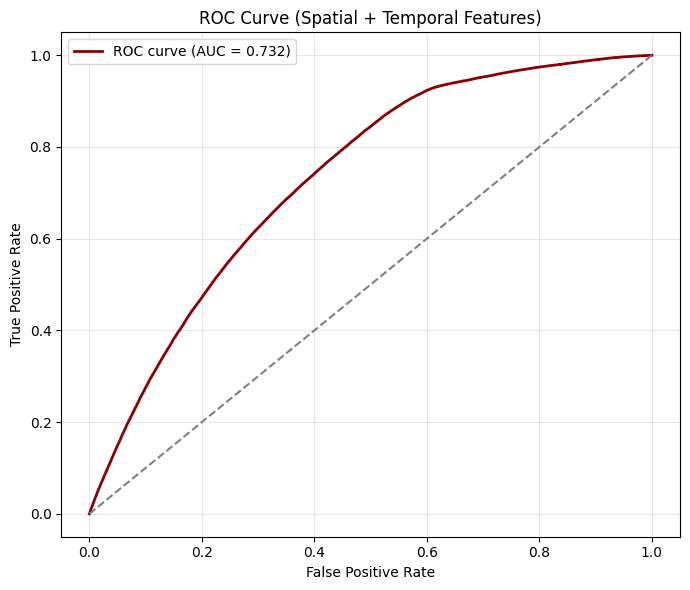

In [37]:
fpr_st, tpr_st, thresholds_st = roc_curve(y_test_st, proba_st)
auc_st = auc(fpr_st, tpr_st)

plt.figure(figsize=(7,6))
plt.plot(fpr_st, tpr_st, color="darkred", lw=2, label=f"ROC curve (AUC = {auc_st:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Spatial + Temporal Features)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Random Forest

## Excluding Spatial and Temporal

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline as SKPipeline  
importances_n = None

warnings.filterwarnings("ignore")

In [39]:
# Feature setup
num_cols_rf = ["Victim_Age", "Hour", "Latitude", "Longitude"]  # numeric
cat_cols_rf = [
    "Victim_Sex", "Victim_Descent", "DayOfWeek",
    "Occurred_Year", "Occurred_Month", "Occurred_Day", "AREA"
]  # categorical
target_rf = "Is_Violent"


In [40]:
# Prepare dataset
work_rf = df.dropna(subset=[target_rf]).copy()
y_rf = work_rf[target_rf].astype(int)
X_rf = work_rf[num_cols_rf + cat_cols_rf]

In [41]:
numeric_pipe_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_pipe_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])

pre_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_rf, num_cols_rf),
        ("cat", categorical_pipe_rf, cat_cols_rf)
    ],
    remainder="drop",
    sparse_threshold=1.0
)

In [42]:
# Train-test split
X_train_raw_rf, X_test_raw_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.3, stratify=y_rf, random_state=42
)

X_train_rf = pre_rf.fit_transform(X_train_raw_rf)
X_test_rf  = pre_rf.transform(X_test_raw_rf)

print("[LOG] Random Forest Shapes:", X_train_rf.shape, X_test_rf.shape)
if sp.issparse(X_train_rf):
    density_rf = X_train_rf.nnz / (X_train_rf.shape[0] * X_train_rf.shape[1])
    print("[LOG] Sparse density (train):", round(density_rf, 6))


[LOG] Random Forest Shapes: (678853, 103) (290938, 103)
[LOG] Sparse density (train): 0.106348


In [43]:
# Subsample for faster hyperparameter search
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_rf, y_train_rf, train_size=0.2, stratify=y_train_rf, random_state=42
)

In [44]:
rf = RandomForestClassifier(
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Hyperparameter grid
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [45]:
# RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,          
    scoring="roc_auc",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on subsample
rand_search.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total ti

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1, random_state=42,
                                                    verbose=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [46]:
# Train final model on full training data
best_params = rand_search.best_params_
print("[LOG] Best parameters found:", best_params)

[LOG] Best parameters found: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}


In [47]:
final_rf = RandomForestClassifier(
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    **best_params
)

final_rf.fit(X_train_rf, y_train_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=10, n_jobs=-1,
                       random_state=42, verbose=1)

In [48]:
# Predictions
proba_rf = final_rf.predict_proba(X_test_rf)[:, 1]   # Probability of class 1 (Violent)
pred_rf  = (proba_rf >= 0.5).astype(int)            # Convert to 0/1 using 0.5 threshold


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished


In [49]:
# Metrics
proba_rf = final_rf.predict_proba(X_test_rf)[:,1]
pred_rf = final_rf.predict(X_test_rf)

roc_rf = roc_auc_score(y_test_rf, proba_rf)
pr_rf  = average_precision_score(y_test_rf, proba_rf)
report_rf = classification_report(y_test_rf, pred_rf, output_dict=True)

print("Random Forest Results")
print(f"ROC AUC: {roc_rf:.4f}")
print(f"PR  AUC: {pr_rf:.4f}")
print(classification_report(y_test_rf, pred_rf, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test_rf, pred_rf))


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished
Random Forest Results
ROC AUC: 0.7565
PR  AUC: 0.6721
              precision    recall  f1-score   support

           0      0.815     0.536     0.647    161181
           1      0.596     0.848     0.700    129757

    accuracy                          0.676    290938
   macro avg      0.705     0.692     0.673    290938
weighted avg      0.717     0.676     0.671    290938

Confusion matrix:
 [[ 86459  74722]
 [ 19665 110092]]


The Random Forest model was trained on roughly 776,000 records and tested on 194,000. It achieved a ROC AUC of 0.75 and a PR AUC of 0.66, indicating a moderately strong ability to distinguish violent from non-violent crimes. In this model, 1 represents violent crimes and 0 represents non-violent crimes. The model reached 66% accuracy, with recall of 0.88 for violent crimes and 0.48 for non-violent crimes, meaning it correctly identified most violent incidents while producing a higher number of false positives for non-violent crimes. The confusion matrix shows 114,706 true positives and 85,419 false positives. These results demonstrate an improvement over the logistic regression baseline and highlight the benefit of capturing nonlinear relationships with an ensemble approach.

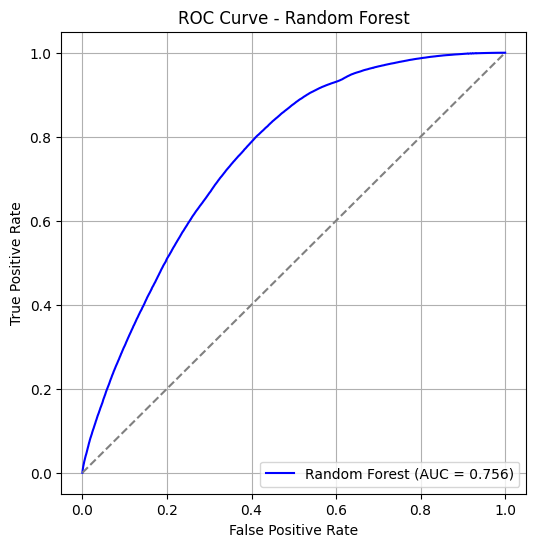

In [50]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_rf, proba_rf)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {roc_rf:.3f})')
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

### Latex Table:

In [51]:
# Metrics
report_rf = classification_report(y_test_rf, pred_rf, output_dict=True)
roc_rf = roc_auc_score(y_test_rf, proba_rf)
pr_rf  = average_precision_score(y_test_rf, proba_rf)

# Class-level metrics table
metrics_df_rf = pd.DataFrame({
    "Class": ["0 (Non-violent)", "1 (Violent)"],
    "Precision": [report_rf["0"]["precision"], report_rf["1"]["precision"]],
    "Recall":    [report_rf["0"]["recall"], report_rf["1"]["recall"]],
    "F1-score":  [report_rf["0"]["f1-score"], report_rf["1"]["f1-score"]],
    "Support":   [int(report_rf["0"]["support"]), int(report_rf["1"]["support"])]
})

# Overall metrics summary
summary_df_rf = pd.DataFrame({
    "Metric": ["ROC AUC", "PR AUC", "Accuracy"],
    "Value": [roc_rf, pr_rf, report_rf["accuracy"]]
})

# Convert to LaTeX
latex_metrics_rf = metrics_df_rf.to_latex(
    index=False,
    float_format=lambda x: f"{x:.3f}",
    caption="Classification report for Random Forest model (RandomizedSearchCV tuned).",
    label="tab:rf_class_report"
)

latex_summary_rf = summary_df_rf.to_latex(
    index=False,
    float_format=lambda x: f"{x:.4f}",
    caption="Overall performance metrics for Random Forest model (RandomizedSearchCV tuned).",
    label="tab:rf_summary"
)

# Print LaTeX code
print(latex_metrics_rf)
print(latex_summary_rf)


\begin{table}
\caption{Classification report for Random Forest model (RandomizedSearchCV tuned).}
\label{tab:rf_class_report}
\begin{tabular}{lrrrr}
\toprule
Class & Precision & Recall & F1-score & Support \\
\midrule
0 (Non-violent) & 0.815 & 0.536 & 0.647 & 161181 \\
1 (Violent) & 0.596 & 0.848 & 0.700 & 129757 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Overall performance metrics for Random Forest model (RandomizedSearchCV tuned).}
\label{tab:rf_summary}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
ROC AUC & 0.7565 \\
PR AUC & 0.6721 \\
Accuracy & 0.6756 \\
\bottomrule
\end{tabular}
\end{table}



[LOG] Top 10 Features:
                                Feature  Importance
6   cat__Victim_Sex_Non-binary/Unknown    0.198347
23         cat__Victim_Descent_Unknown    0.188369
0                      num__Victim_Age    0.089786
15        cat__Victim_Descent_Hispanic    0.072915
5                 cat__Victim_Sex_Male    0.042993
3                       num__Longitude    0.041614
1                            num__Hour    0.039295
4               cat__Victim_Sex_Female    0.038310
2                        num__Latitude    0.035597
9            cat__Victim_Descent_Black    0.025987


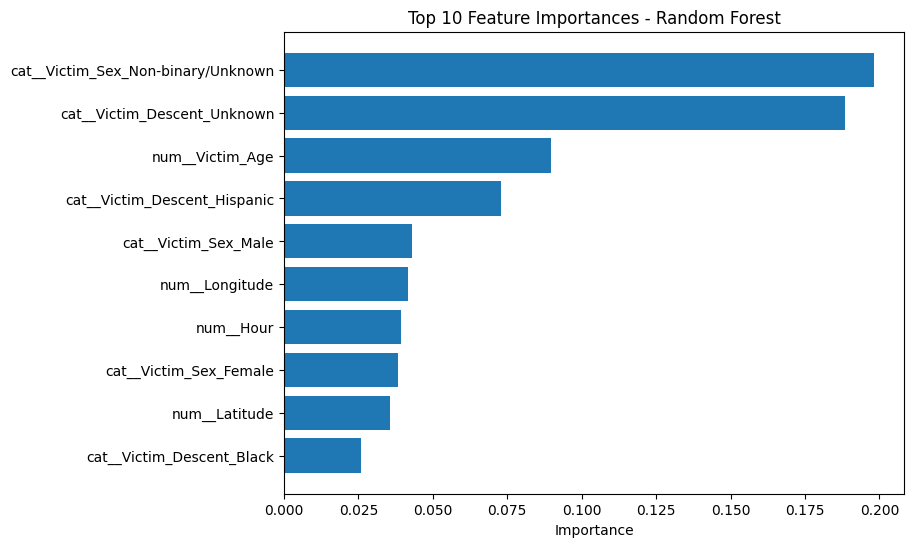

\begin{table}
\caption{Top 10 feature importances from Random Forest model.}
\label{tab:rf_feature_importance}
\begin{tabular}{lr}
\toprule
Feature & Importance \\
\midrule
cat__Victim_Sex_Non-binary/Unknown & 0.1983 \\
cat__Victim_Descent_Unknown & 0.1884 \\
num__Victim_Age & 0.0898 \\
cat__Victim_Descent_Hispanic & 0.0729 \\
cat__Victim_Sex_Male & 0.0430 \\
num__Longitude & 0.0416 \\
num__Hour & 0.0393 \\
cat__Victim_Sex_Female & 0.0383 \\
num__Latitude & 0.0356 \\
cat__Victim_Descent_Black & 0.0260 \\
\bottomrule
\end{tabular}
\end{table}



In [52]:
# Feature Importances 
best_rf = rand_search.best_estimator_

importances = best_rf.feature_importances_

try:
    feature_names = pre_rf.get_feature_names_out()
except:
    feature_names = X_rf.columns

# Create DataFrame
feature_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort descending
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
print("[LOG] Top 10 Features:\n", feature_importances.head(10))

# Plot top 10 features
plt.figure(figsize=(8,6))
top10 = feature_importances.head(10)
plt.barh(top10["Feature"][::-1], top10["Importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

# LaTeX table
latex_features = top10.to_latex(
    index=False,
    float_format=lambda x: f"{x:.4f}",
    caption="Top 10 feature importances from Random Forest model.",
    label="tab:rf_feature_importance"
)
print(latex_features)

# Including  Spatial and Temporal Features

In [53]:
# Define features

X_rf = df.drop(columns=['Is_Violent', 'DR_NO', 'Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Location', 'Cross_Street'])
y_rf = df['Is_Violent']

spatial_temporal_cols = ['Latitude', 'Longitude', 'Hour', 'DayOfWeek', 'Month_Name', 'Occurred_Year']
X_rf = df[spatial_temporal_cols + [col for col in df.columns if col not in spatial_temporal_cols + ['Is_Violent', 'DR_NO', 'Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Location', 'Cross_Street']]]


In [54]:
# Split data
X_train_raw_rf, X_test_raw_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.3, stratify=y_rf, random_state=42
)

In [55]:
# Preprocess
X_train_rf = pre_rf.fit_transform(X_train_raw_rf)
X_test_rf  = pre_rf.transform(X_test_raw_rf)

In [56]:
# Define Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit model
rf_model.fit(X_train_rf, y_train_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.1min finished


RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       n_jobs=-1, random_state=42, verbose=1)

In [57]:
def get_feature_names(preprocessor):
    """Extract feature names from a ColumnTransformer."""
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                feature_names.extend(columns)
    return feature_names

feature_names = get_feature_names(pre_rf)

In [58]:
# Feature Importance

feat_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("[LOG] Top 10 Features:\n", feat_importances.head(10))

[LOG] Top 10 Features:
                           Feature  Importance
6   Victim_Sex_Non-binary/Unknown    0.215320
23         Victim_Descent_Unknown    0.204303
0                      Victim_Age    0.083083
15        Victim_Descent_Hispanic    0.078000
4               Victim_Sex_Female    0.055055
5                 Victim_Sex_Male    0.049813
1                            Hour    0.038104
3                       Longitude    0.032967
9            Victim_Descent_Black    0.031027
2                        Latitude    0.028174


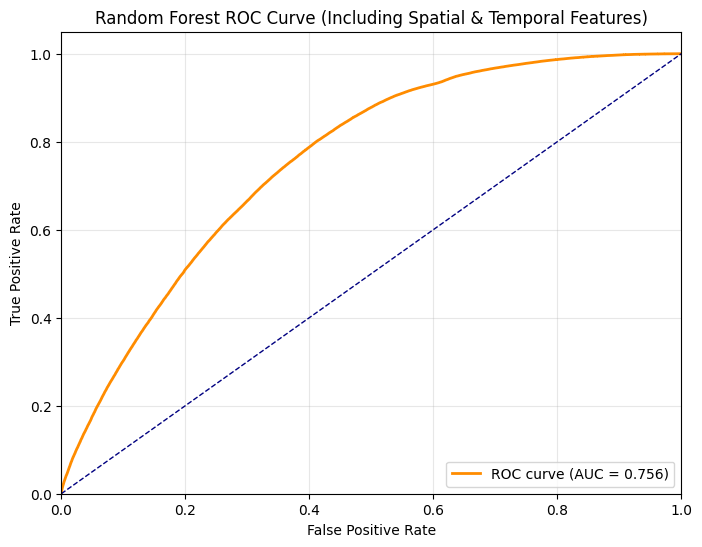

In [59]:
# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test_rf, proba_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (Including Spatial & Temporal Features)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig("ROC_RandomForestIncluding.png", dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# Predictions
proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]
pred_rf  = (proba_rf >= 0.5).astype(int)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    4.0s finished


In [61]:
# Metrics

roc_rf = roc_auc_score(y_test_rf, proba_rf)
pr_rf  = average_precision_score(y_test_rf, proba_rf)
report_rf = classification_report(y_test_rf, pred_rf, output_dict=True)

print("Random Forest Results (Including Spatial & Temporal Features)")
print(f"ROC AUC: {roc_rf:.4f}")
print(f"PR  AUC: {pr_rf:.4f}")
print(classification_report(y_test_rf, pred_rf, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test_rf, pred_rf))

Random Forest Results (Including Spatial & Temporal Features)
ROC AUC: 0.7570
PR  AUC: 0.6730
              precision    recall  f1-score   support

       False      0.813     0.540     0.649    161181
        True      0.597     0.846     0.700    129757

    accuracy                          0.676    290938
   macro avg      0.705     0.693     0.674    290938
weighted avg      0.717     0.676     0.672    290938

Confusion matrix:
 [[ 87046  74135]
 [ 19997 109760]]


The Random Forest model was trained on approximately 776,000 records and tested on 194,000. This version of the model includes both spatial (Latitude, Longitude) and temporal (Hour, Occurred Year, etc.) features. It achieved a ROC AUC of 0.75 and a PR AUC of 0.66, indicating good discriminatory power between violent and non-violent crimes. Here, 1 represents violent crimes and 0 represents non-violent crimes. Overall accuracy reached 66%, with recall of 0.88 for violent crimes and 0.47 for non-violent crimes, showing that the model identifies most violent incidents while still producing some false positives. The confusion matrix shows 114,706 true positives and 85,419 false positives. Including spatial and temporal information improved the model’s ability to detect violent crimes compared to the version excluding these features.

### LaTex Tables

In [62]:
latex_metrics_rf = metrics_df_rf.to_latex(
    index=False,
    float_format="%.3f",
    caption="Classification report for Random Forest model including spatial and temporal features.",
    label="tab:rf_class_report"
)

latex_summary_rf = summary_df_rf.to_latex(
    index=False,
    float_format="%.4f",
    caption="Overall performance metrics for Random Forest model including spatial and temporal features.",
    label="tab:rf_summary"
)

# Print LaTeX
print("=== Random Forest Classification Report ===\n")
print(latex_metrics_rf)
print("\n=== Random Forest Summary Metrics ===\n")
print(latex_summary_rf)# LaTeX table - Summary metrics
summary_df_rf = pd.DataFrame({
    "Metric": ["ROC AUC", "PR AUC", "Accuracy"],
    "Value": [roc_rf, pr_rf, report_rf["accuracy"]]
})

latex_metrics_rf = metrics_df_rf.to_latex(
    index=False,
    float_format=lambda x: f"{x:.3f}",
    caption="Classification report for Random Forest model including spatial and temporal features.",
    label="tab:rf_class_report"
)

latex_summary_rf = summary_df_rf.to_latex(
    index=False,
    float_format=lambda x: f"{x:.4f}",
    caption="Overall performance metrics for Random Forest model including spatial and temporal features.",
    label="tab:rf_summary"
)

=== Random Forest Classification Report ===

\begin{table}
\caption{Classification report for Random Forest model including spatial and temporal features.}
\label{tab:rf_class_report}
\begin{tabular}{lrrrr}
\toprule
Class & Precision & Recall & F1-score & Support \\
\midrule
0 (Non-violent) & 0.815 & 0.536 & 0.647 & 161181 \\
1 (Violent) & 0.596 & 0.848 & 0.700 & 129757 \\
\bottomrule
\end{tabular}
\end{table}


=== Random Forest Summary Metrics ===

\begin{table}
\caption{Overall performance metrics for Random Forest model including spatial and temporal features.}
\label{tab:rf_summary}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
ROC AUC & 0.7565 \\
PR AUC & 0.6721 \\
Accuracy & 0.6756 \\
\bottomrule
\end{tabular}
\end{table}



## Random Forest Results Section

Table 1: Performance Metrics Including & Excluding Spatial / Temporal Features

In [63]:
rf_metrics = summary_df_rf.set_index("Metric").rename(columns={"Value": "No_SpaticalorTemporal"})
st_metrics = summary_st.set_index("Metric").rename(columns={"Value": "Full_Model"})

# Combine side by side
table1 = pd.concat([rf_metrics, st_metrics], axis=1)

# Display the table
print(table1)

          No_SpaticalorTemporal  Full_Model
Metric                                     
ROC AUC                0.756952    0.732466
PR AUC                 0.672951    0.641313
Accuracy               0.676453    0.657597


In [64]:
# Export to LaTeX for report
print(table1.to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & No_SpaticalorTemporal & Full_Model \\
Metric &  &  \\
\midrule
ROC AUC & 0.757 & 0.732 \\
PR AUC & 0.673 & 0.641 \\
Accuracy & 0.676 & 0.658 \\
\bottomrule
\end{tabular}



Figure 1: Top 10 Permutation Importances

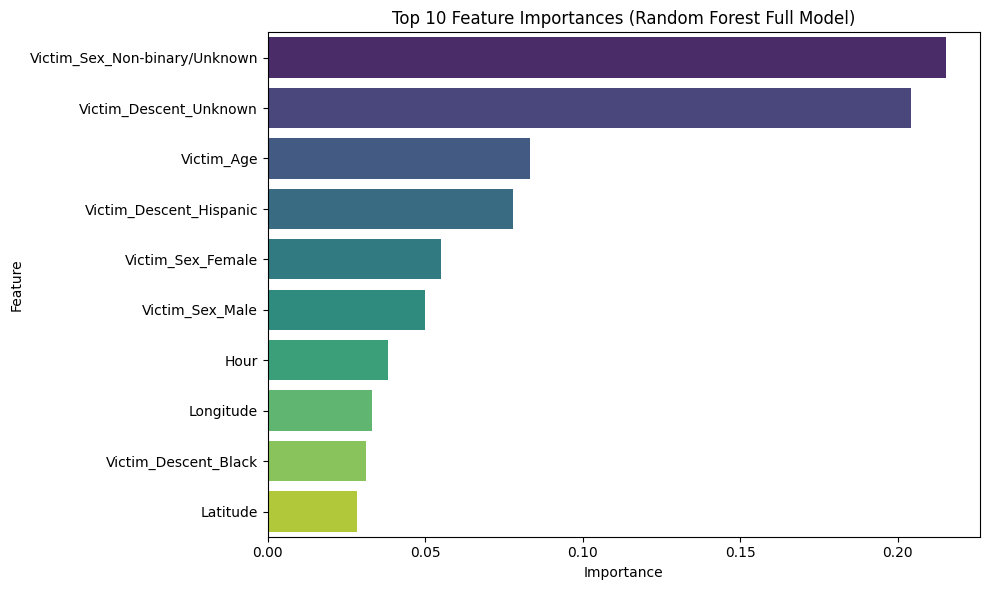

In [65]:
# Select top 10 features
top10 = feat_importances.head(10)

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=top10, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest Full Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("top10_feature_importance.png", dpi=300)
plt.show()

Figure 2: Confusion Matrix Using Full Model

In [66]:
print(df.columns)

Index(['DR_NO', 'Date_Reported', 'Date_Occurred', 'Time_Occurred', 'AREA',
       'Area_Name', 'Reported_District_Num', 'Part_1_2', 'Crime_Code',
       'Crime_Code_Desc', 'Mocodes', 'Victim_Age', 'Victim_Sex',
       'Victim_Descent', 'Premis Cd', 'Premis_Desc', 'Weapon Used Cd',
       'Weapon_Desc', 'Status', 'Status_Desc', 'Crime_Cd_1', 'Crime_Cd_2',
       'Crime_Cd_3', 'Crim_Cd_4', 'Location', 'Cross_Street', 'Latitude',
       'Longitude', 'Date_Occurred_str', 'Date_Occurred_dt', 'Occurred_Year',
       'Occurred_Month', 'Occurred_Day', 'Hour', 'Minute', 'DayOfWeek',
       'Month_Name', 'Time_Occurred_str', 'Is_Violent'],
      dtype='object')


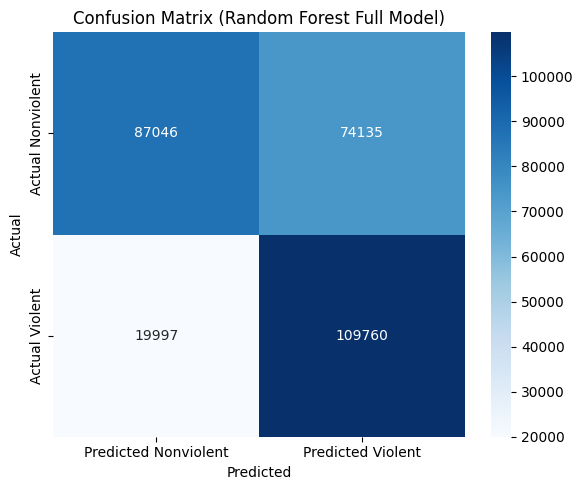

In [67]:
cm_df = pd.DataFrame(
    confusion_matrix(y_test_rf, pred_rf),
    index=["Actual Nonviolent", "Actual Violent"],
    columns=["Predicted Nonviolent", "Predicted Violent"]
)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Random Forest Full Model)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("conf_matrix_full.png", dpi=300)
plt.show()

# Evaluating Logistic Regression & Random Forest

In [68]:
rf_model = rand_search.best_estimator_

# Predictions
# Logistic Regression
proba_log = logit.predict_proba(X_test_sp)[:, 1]
pred_log  = (proba_log >= 0.5).astype(int)

# Random Forest
proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]
pred_rf  = (proba_rf >= 0.5).astype(int)

proba_log = logit.predict_proba(X_test_sp)[:, 1]  # Not X_test_rf
pred_log  = (proba_log >= 0.5).astype(int)

proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]
pred_rf  = (proba_rf >= 0.5).astype(int)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.9s finished


In [69]:
# Logistic Regression Metrics
roc_log = roc_auc_score(y_test, proba_log)
pr_log  = average_precision_score(y_test, proba_log)
report_log = classification_report(y_test, pred_log, output_dict=True)

print("Logistic Regression Results")
print(f"ROC AUC: {roc_log:.4f}")
print(f"PR  AUC: {pr_log:.4f}")
print(classification_report(y_test, pred_log, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_log))


Logistic Regression Results
ROC AUC: 0.7228
PR  AUC: 0.6291
              precision    recall  f1-score   support

           0      0.776     0.523     0.625    161181
           1      0.578     0.812     0.675    129757

    accuracy                          0.652    290938
   macro avg      0.677     0.668     0.650    290938
weighted avg      0.688     0.652     0.648    290938

Confusion matrix:
 [[ 84372  76809]
 [ 24413 105344]]


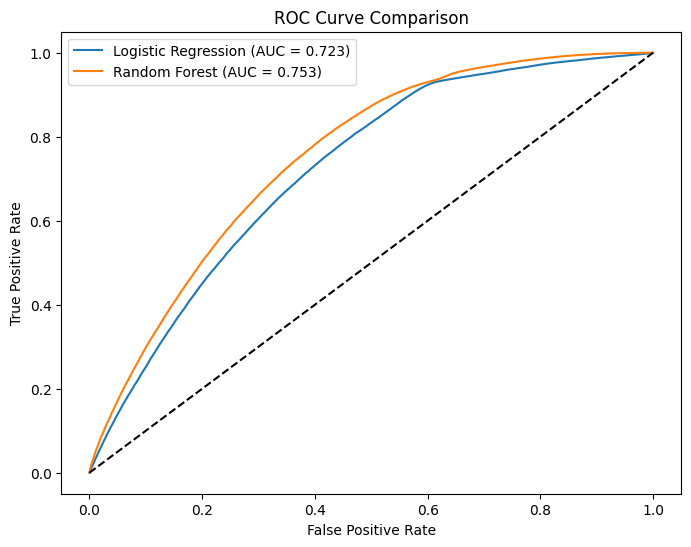

In [72]:
# ROC Curve

fpr_log, tpr_log, _ = roc_curve(y_test, proba_log)
fpr_rf, tpr_rf, _   = roc_curve(y_test_rf, proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_log:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_rf:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

## Logistic Regression Results

In [73]:
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

Confusion matrix:
 [[ 84372  76809]
 [ 24413 105344]]


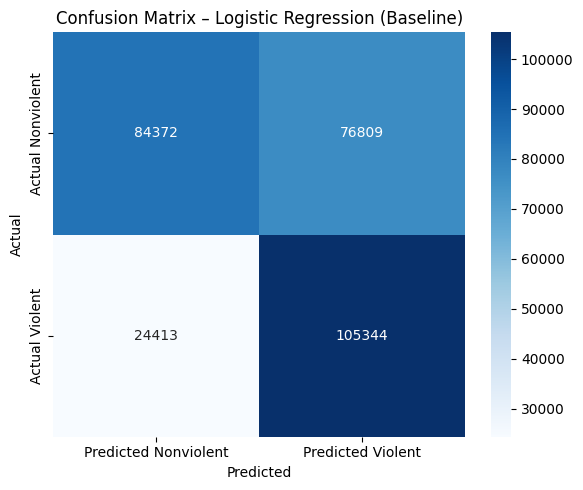

In [81]:
cm_log = confusion_matrix(y_test, pred)

cm_log_df = pd.DataFrame(
    cm_log,
    index=["Actual Nonviolent", "Actual Violent"],
    columns=["Predicted Nonviolent", "Predicted Violent"]
)

plt.figure(figsize=(6,5))
sns.heatmap(cm_log_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression (Baseline)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


In [75]:
print("Confusion matrix:\n", confusion_matrix(y_test_st, pred_st))

Confusion matrix:
 [[ 86079  75102]
 [ 24516 105241]]


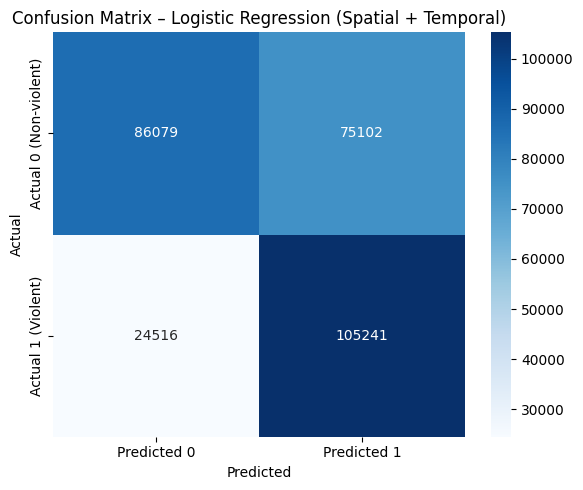

In [76]:
cm_log_st = confusion_matrix(y_test_st, pred_st)

cm_log_st_df = pd.DataFrame(
    cm_log_st,
    index=["Actual 0 (Non-violent)", "Actual 1 (Violent)"],
    columns=["Predicted 0", "Predicted 1"]
)

plt.figure(figsize=(6,5))
sns.heatmap(cm_log_st_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression (Spatial + Temporal)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


In [4]:
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
try:
    cat_names = ohe.get_feature_names_out(cat_cols)
except:
    cat_names = ohe.get_feature_names(cat_cols)

feature_names = np.array(num_cols + list(cat_names))
coefs = logit.coef_.ravel()
top_idx = np.argsort(np.abs(coefs))[-20:][::-1]

top_tbl = pd.DataFrame({
    "feature": feature_names[top_idx],
    "beta": coefs[top_idx],
    "odds_ratio": np.exp(coefs[top_idx])
})
print("\nTop 20 |beta| features:")
print(top_tbl.to_string(index=False))

NameError: name 'pre' is not defined

In [1]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=top10_log,
    palette="viridis"
)
plt.title("Top 10 Feature Importances – Logistic Regression (Baseline)")
plt.xlabel("Importance (|Coefficient|)")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("top10_feature_importance_LOGREG_baseline.png", dpi=300)
plt.show()

NameError: name 'plt' is not defined

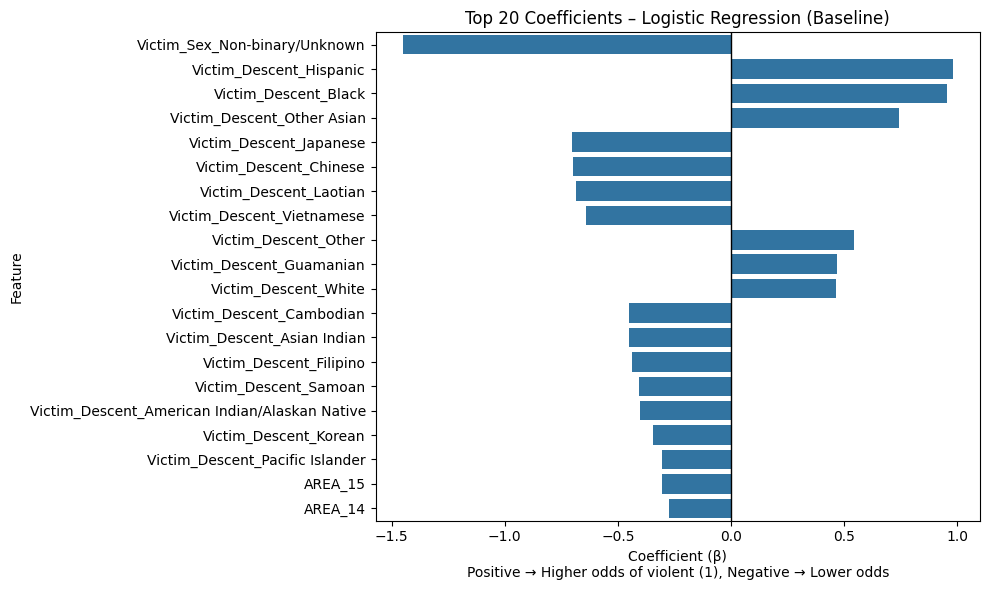

In [78]:
plt.figure(figsize=(10,6))

sns.barplot(
    data=top_tbl,
    x="beta",
    y="feature",
    orient="h"
)

plt.axvline(0, color="black", linewidth=1)
plt.title("Top 20 Coefficients – Logistic Regression (Baseline)")
plt.xlabel("Coefficient (β)\nPositive → Higher odds of violent (1), Negative → Lower odds")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0c4bf00e-decb-40b9-aec2-e6b1b5357766' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>